In [1]:
from river import stream
from river.datasets import base
class SolarFlare(base.FileDataset):
    def __init__(self):
        super().__init__(
            n_samples=1066,
            n_features=10,
            n_outputs=1,
            task=base.MO_REG,
            filename="solar-flare.csv.zip",
        )
    def __iter__(self):
        return stream.iter_csv(
            self.path,
            target="m-class-flares",
            converters={
                "zurich-class": str,
                "largest-spot-size": str,
                "spot-distribution": str,
                "activity": int,
                "evolution": int,
                "previous-24h-flare-activity": int,
                "hist-complex": int,
                "hist-complex-this-pass": int,
                "area": int,
                "largest-spot-area": int,
                "c-class-flares": int,
                "m-class-flares": int,
                "x-class-flares": int,
            },
        )


In [2]:
from pprint import pprint
from river import datasets
for x, y in SolarFlare():
    pprint(x)
    pprint(y)
    break


{'activity': 1,
 'area': 1,
 'c-class-flares': 0,
 'evolution': 3,
 'hist-complex': 1,
 'hist-complex-this-pass': 1,
 'largest-spot-area': 1,
 'largest-spot-size': 'A',
 'previous-24h-flare-activity': 1,
 'spot-distribution': 'X',
 'x-class-flares': 0,
 'zurich-class': 'H'}
0


In [3]:
import numbers
from river import compose
from river import preprocessing
from river import tree
num = compose.SelectType(numbers.Number) | preprocessing.MinMaxScaler()
cat = compose.SelectType(str) | preprocessing.OneHotEncoder(sparse=False)
model = tree.HoeffdingTreeRegressor()
pipeline = (num + cat) | model


In [4]:
from river import evaluate
from river import metrics
metric = metrics.MAE()
evaluate.progressive_val_score(SolarFlare(), pipeline, metric)


MAE: 0.086402

In [5]:
errors = []
for x, y in SolarFlare():
    y_pred = pipeline.predict_one(x)
    metric = metric.update(y, y_pred)
    errors.append(metric.get())
    pipeline = pipeline.learn_one(x, y)


Text(0, 0.5, 'MAE')

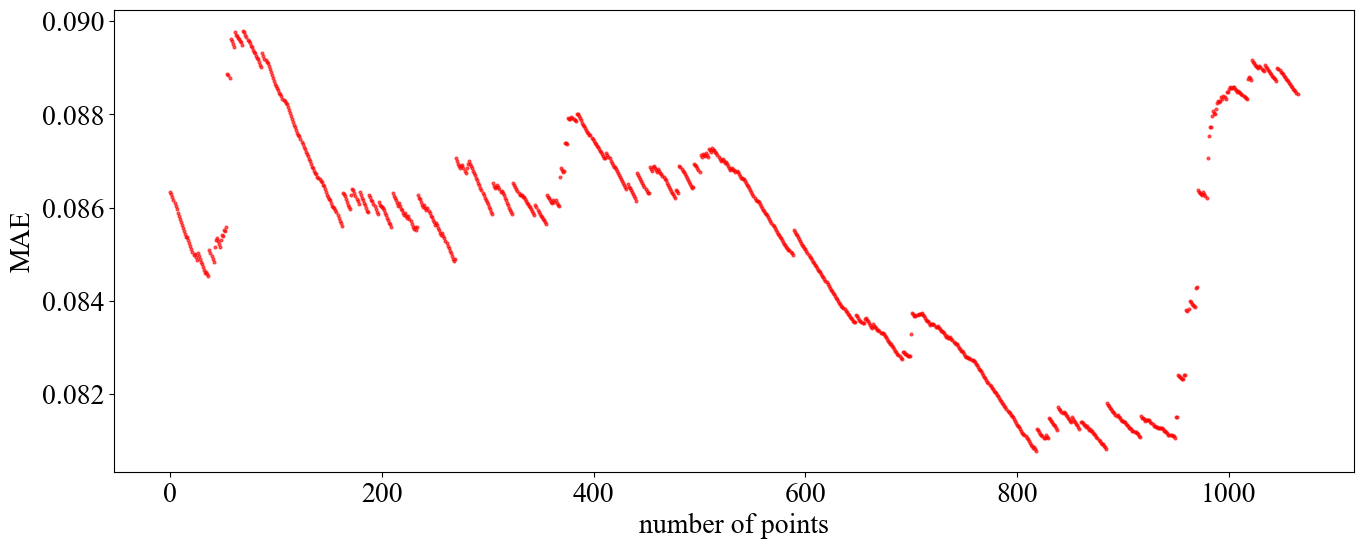

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    errors,
    "ro",
    alpha=0.6,
    markersize=2,
    linewidth=4
)
ax.set_xlabel("number of points")
ax.set_ylabel("MAE")


In [11]:
from river import (
    ensemble, tree,
    evaluate, metrics
)
from river.datasets import synth
models = [
    tree.HoeffdingTreeRegressor(),
    tree.HoeffdingAdaptiveTreeRegressor(),
    ensemble.AdaptiveRandomForestRegressor(seed=42)
]


In [12]:
for model in models:
    metric = metrics.MSE()
    dataset = synth.ConceptDriftStream(
        seed=42, position=500, width=40
    ).take(1000)
    evaluate.progressive_val_score(dataset, model, metric)
    print(f"{str(model.__class__).split('.')[-1][:-2]}: {metric.get():e}")


HoeffdingTreeRegressor: 5.648298e+15
HoeffdingAdaptiveTreeRegressor: 1.136058e+16
AdaptiveRandomForestRegressor: 1.412074e+17
